In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mp
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from textwrap import wrap
import h5py, time
from cpnLES_MSCARTlib import DHARMA_onmp,LES_field
import cpnCommonlib as cpn
cpn.setup_figures(plt)


In [14]:
DYCOMS2.DHARMA.dN_drops.shape

(25, 96, 128, 128)

In [15]:
w_tau.shape

(96, 128, 128)

In [28]:
DYCOMS2.dTau.shape

(3, 96, 128, 128)

## Vertically weighted and CER and CEV 
Vertical weighting method based on two-way transmittance (Platnick et. al. 2000, Alexandrove et. al. 2012, Zhang et. al. 2017, Miller et. al. 2016) can be impleted via two approaches. 

#### (1) First, find $r_e(\tau)$ (or $v_e(\tau)$) and user vertical weighting function to get the weighted value, $r_{e,vw}$ 

#### (2) Find the vertically-weighted size distribution $N_{VW}$ and then use to find $r_e$ and $v_e$ \
From Miller et. al.\
$N_{VW}(r)=\int_0^{\tau_{tot}}{N(r,\tau)w(\tau)d\tau}$

Hansen & Travis 1974 2.53 \
$r_{e,Nvw}=\frac{\int{Q_e(r)\omega(r)r^3N_{VW}(r)dr}}{\int{Q_e(r)\omega(r)r^2N_{VW}(r)dr}}$

Hansen & Travis 1974 2.54 \
$v_{e,Nvw}=\frac{1}{r_{e,Nvw}^2}\frac{\int{(r-r_{e,Nvw})^2\pi r^2N_{VW}(r)dr}}{\int{\pi r^2N_{VW}(r)dr}}$

#### Generalized implementation

In [ ]:
DYCOMS2_path  ='/umbc/xfs1/zzbatmos/users/charaj1/LES_simulations/DYCOMS/Ackerman_DYCOMS2_25bins/'
DYCOMS2=DHARMA_onmp('dharma_008036.cdf',DYCOMS2_path );DYCOMS2.readDHARMA()
mie_path='/umbc/xfs1/zzbatmos/users/charaj1/LES_simulations/'
mie_name='DYCOM2_dharma_008036_mie_470_860_2p13'
lesCname='DYCOMS2';lesBinEd=None
a=1;b=0;SZA=20;VZA=0
band=1
wvl={1:'0p860',2:'2p13'}
#Re_vw,Ve_vw,dN_vw,re_tau,ve_tau,w_tau,tau,re_dN_vw,ve_dN_vw=DYCOMS2.find_reVW(mie_name,lesCname,SZA,VZA,a=a,b=b,mie_path=mie_path,band=band)        
DYCOMS2.setup_reVW(mie_name,lesCname,SZA,VZA,a=a,b=b,mie_path=mie_path,band=band)

self.c_mie created!
File name: dharma_008036_DYCOM2_dharma_008036_mie_470_860_2p13_SZA020_VZA000_b0p860a1_b0
File already exist in: /umbc/xfs1/zzbatmos/users/charaj1/taki/ACRS/LES_simulations/


Replace/Reload 1/0: 1


Previous results will be replaced!
self.c_mie created!
Make sure to give correct lesCname.
self.qe_avg, self.alb_av created
self.zTau, self.zTau0top created.
Calculating re and ve ...


/umbc/xfs1/zzbatmos/users/charaj1/taki/ACRS/LES_simulations/cpnLES_MSCARTlib.py:1286: RuntimeWarning: divide by zero encountered in true_divide
  re_tau=num/den
/umbc/xfs1/zzbatmos/users/charaj1/taki/ACRS/LES_simulations/cpnLES_MSCARTlib.py:1286: RuntimeWarning: invalid value encountered in true_divide
  re_tau=num/den


#### Test implementation

In [56]:
def find_reVW(obj,mie_name,lesCname,dgSZA,dgVZA,a=1,b=0,lesBinEd=None,mie_path=None,band=None):
    '''
    Two parameter bidirectional weighting function implementation for both re and ve
    Platnick et. al. (2000), Alexandrov et. al. (2012), Zhang et. al. (2017), Miller et. al. (2017)
    -----------------------------------------------------------------------------------------------
    mie_name: Mie file name without extenction
    lesCname: see self.get_pDefr_l for lesCname/lesBinEd
    dgSZA,dgVZA: Solar zenith and viewing zenith in degrees respectively
    a,b: W=tau**b*exp(-a*B*tau)
    '''
    start=time.time()
    if lesCname is not None:
        obj.setup_dTau(mie_name,lesCname,mie_path=mie_path)
    elif lesBinEd is not None:
        obj.setup_dTau(mie_name,lesBinEd=lesBinEd,mie_path=mie_path)
    if band is None:
        band=1
        print('Deafault wavelength %0.3f was selected'%(obj.c_mie.wvl[band]))
        print('Available wavelengths:'+str(obj.c_mie.wvl))
    obj.zTau=np.cumsum(obj.dTau,axis=1)
    obj.zTau0top=np.zeros_like(obj.zTau,dtype=float)
    for i in np.arange(obj.x.size):
        for j in np.arange(obj.y.size):
            for wv in np.arange(3):
                obj.zTau0top[wv,:,i,j]=obj.zTau[wv,:,i,j].max()-obj.zTau[wv,:,i,j]
    print('self.zTau, self.zTau0top created.')
    tau=TAU_W086.swapaxes(1,2)#obj.zTau0top[band,:]
    sza=np.deg2rad(dgSZA)
    vza=np.deg2rad(dgVZA)
    B=1/np.cos(sza)+1/np.cos(vza)
    c=1/np.einsum('zxy,zxy->xy',tau**b*np.exp(-a*B*tau),obj.dTau[band,:])
    #c=1/np.trapz(tau**b*np.exp(-a*B*tau),tau,axis=0)
    w_tauDIVc=tau**b*np.exp(-a*B*tau)
    print('Calculating re and ve ...')
    #calculating re_tau (Hansen & Travis 1974 2.53)
    num=np.einsum('r,rzxy->rzxy',obj.qe_avg[band,:]*obj.alb_av[band,:]*obj.DHARMA.r_drops**3,obj.DHARMA.dN_drops)
    num=np.trapz(num,obj.DHARMA.r_drops,axis=0)
    den=np.einsum('r,rzxy->rzxy',obj.qe_avg[band,:]*obj.alb_av[band,:]*obj.DHARMA.r_drops**2,obj.DHARMA.dN_drops)
    den=np.trapz(den,obj.DHARMA.r_drops,axis=0)
    re_tau=num/den
    Re_vw=c*np.einsum('zxy,zxy->xy',re_tau*w_tauDIVc,obj.dTau[band,:])
    #Re_vw=c*np.trapz(re_tau*w_tauDIVc,tau,axis=0)
    #calculating ve_tau (Hanse & Travis 1974 2.54)
    rMinre=np.zeros_like(obj.DHARMA.dN_drops,dtype=float)
    for i in np.arange(obj.x.size):
        for j in np.arange(obj.y.size):
            for k in np.arange(obj.DHARMA.z.size):
                rMinre[:,k,i,j]=obj.DHARMA.r_drops-re_tau[k,i,j]
    num=np.einsum('r,rzxy->rzxy',obj.qe_avg[band,:]*obj.alb_av[band,:]*obj.DHARMA.r_drops**2,obj.DHARMA.dN_drops*rMinre**2)
    num=np.trapz(num,obj.DHARMA.r_drops,axis=0)
    ve_tau=num/den/re_tau**2
    Ve_vw=c*np.einsum('zxy,zxy->xy',ve_tau*w_tauDIVc,obj.dTau[band,:])
    #Ve_vw=c*np.trapz(ve_tau*w_tauDIVc,tau,axis=0)
    w_tau=np.zeros_like(w_tauDIVc,dtype=float)
    for i in np.arange(obj.x.size):
        for j in np.arange(obj.y.size):
            w_tau[:,i,j]=w_tauDIVc[:,i,j]*c[i,j]
    #computing vertically weighted number concentration
    dN_vw = -np.einsum('izxy,zxy,zxy->ixy',obj.DHARMA.dN_drops,w_tau,obj.dTau[band,:])
    #computing re_dN_vw, re from vertically weighted DSDs (Hansen & Travis 1974 2.53, Miller et. al. 2016)
    num = np.einsum('r,rxy->rxy',obj.qe_avg[band,:]*obj.alb_av[band,:]*obj.DHARMA.r_drops**3,dN_vw)
    num = np.trapz(num,obj.DHARMA.r_drops,axis=0)
    den = np.einsum('r,rxy->rxy',obj.qe_avg[band,:]*obj.alb_av[band,:]*obj.DHARMA.r_drops**2,dN_vw)
    den = np.trapz(den,obj.DHARMA.r_drops,axis=0)
    re_dN_vw = num/den
    #computing ve_dN_vw, ve from vertically weighted DSDs (Hnasen & Travis 1974 2.53, Miller et. al. 2016)
    ve_dN_vw=np.zeros_like(den,dtype=float)
    for i in np.arange(obj.x.size):
        for j in np.arange(obj.y.size):
            rMinre = obj.DHARMA.r_drops-re_dN_vw[i,j]
            num    = obj.qe_avg[band,:]*obj.alb_av[band,:]*obj.DHARMA.r_drops**2*dN_vw[:,i,j]*rMinre**2
            num    = np.trapz(num,obj.DHARMA.r_drops)
            ve_dN_vw[i,j] = 1/re_dN_vw[i,j]**2*num/den[i,j]

    #calculating vertically weighted cloud optical thickness ?? (:D LOL)
    end=time.time()
    print('%0.2f mins elapsed!'%((end-start)/60))
    return Re_vw,Ve_vw,dN_vw,re_tau,ve_tau,w_tau,tau,re_dN_vw,ve_dN_vw

DYCOMS2_path  ='/umbc/xfs1/zzbatmos/users/charaj1/LES_simulations/DYCOMS/Ackerman_DYCOMS2_25bins/'
DYCOMS2=DHARMA_onmp('dharma_008036.cdf',DYCOMS2_path );DYCOMS2.readDHARMA()
mie_path='/umbc/xfs1/zzbatmos/users/charaj1/LES_simulations/'
mie_name='DYCOM2_dharma_008036_mie_470_860_2p13'
lesCname='DYCOMS2';lesBinEd=None
a=1;b=0;SZA=40;VZA=0
band=1
wvl={1:'0p860',2:'2p13'}
Re_vw,Ve_vw,dN_vw,re_tau,ve_tau,w_tau,tau,re_dN_vw,ve_dN_vw = find_reVW(DYCOMS2,mie_name,lesCname,SZA,VZA,a=1,b=0,mie_path=mie_path,band=None)


self.c_mie created!
Make sure to give correct lesCname.
self.qe_avg, self.alb_av created
Deafault wavelength 0.860 was selected
Available wavelengths:[0.47 0.86 2.13]
self.zTau, self.zTau0top created.
Calculating re and ve ...
2.03 mins elapsed!


Comparing COT with Miller et. al. 2017

In [27]:
mil_fname = 'DHARMA_DYCOMS2_008036_Physics_Optics_VW.h5'
path='/umbc/xfs1/zzbatmos/users/charaj1/taki/ACRS/LES_simulations/Miller_2017/'
f=h5py.File(path+mil_fname,'r')
#tau_w086=f['TAU_W086'][:]
#re_2wt_50m=f['RE_2WT_50m'][:]
#ve_2wt_50m=f['VE_2WT_50m'][:]
#re_2wt_100m=f['RE_2WT_100m'][:]
#dn_drops = f['DN_DROPS'][:]
TAU_W086 = f['TAU_W086'][:]

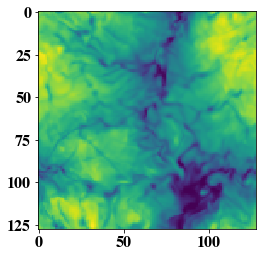

In [34]:
plt.imshow(tau[1,:])

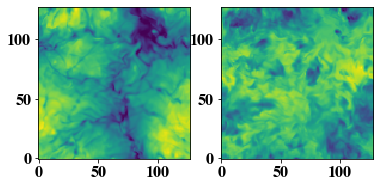

In [38]:
zi = 2
fig1,ax1 = plt.subplots(1,2)
ax1[0].imshow(TAU_W086[zi,:].T,origin='lower')
ax1[1].imshow(tau[zi,:] - TAU_W086[zi,:].T,origin='lower')

### Profile analysis

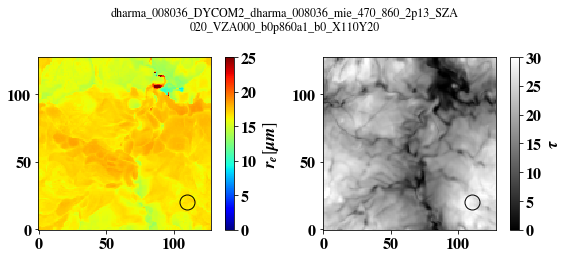

In [3]:
x,y=110,20
fig1,ax1=plt.subplots(1,2,figsize=(8,4),subplot_kw={'aspect':'equal'})
fig1_ttl=DYCOMS2.VW.fname+'_X{}Y{}'.format(x,y)
ctf1=ax1[0].imshow(DYCOMS2.VW.Re,origin='lower',vmin=0,vmax=25,cmap=plt.cm.jet)
ctf2=ax1[1].imshow(DYCOMS2.VW.Tau,origin='lower',vmin=0,vmax=30,cmap=plt.cm.binary_r)
ax1[0].plot(x,y,'ko',markersize=15,markerfacecolor='none')
ax1[1].plot(x,y,'ko',markersize=15,markerfacecolor='none')
cpn.add_cb(fig1,ctf1,ax1[0],orientation='vertical',label=r'$r_e$[$\mu m$]',ticks=np.arange(0,25.1,5))
cpn.add_cb(fig1,ctf2,ax1[1],orientation='vertical',label=r'$\tau$',ticks=np.arange(0,30.1,5))
#ax1[1].tick_params(labelleft=False)
fig1.suptitle("\n".join(wrap(fig1_ttl,55)))
fig1.tight_layout()
#cpn.savefig(fig1,fig1_ttl,'figures/')

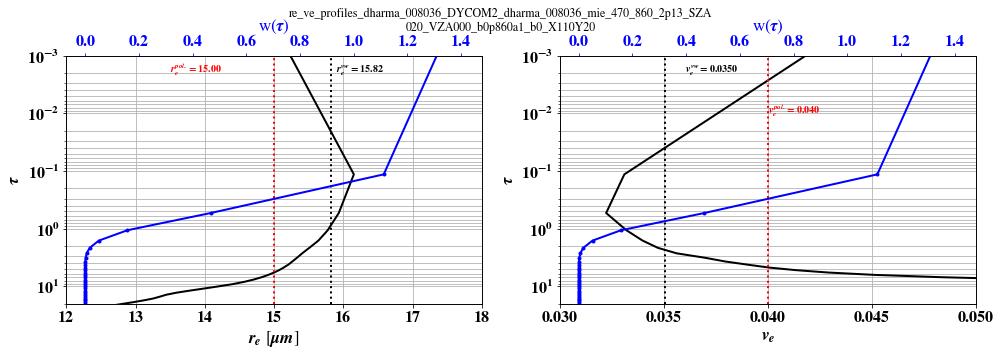

In [4]:
x,y=110,20
fig1,ax1 = plt.subplots(1,2,figsize=(14,5))
fig1_ttl = 're_ve_profiles_'+DYCOMS2.VW.fname+'_X{}Y{}'.format(x,y)
fig1.suptitle("\n".join(wrap(fig1_ttl)))
#CER
ax1[0].plot(DYCOMS2.VW.re_tau[:,x,y],DYCOMS2.VW.tau[:,x,y],'k-',label=r'$r_e$($\tau$)')
ax1[0].set_ylabel(r'$\tau$')
ax1[0].set_xlabel(r'$r_e$ [$\mu m$]')
ax1[0].invert_yaxis()
ax1[0].set_xlim(12,18)
ax1[0].set_ylim(20,0.001)
ax1[0].set_yscale('log')
ax1[0].grid(which='both')
ax12 = ax1[0].twiny()
ax12.plot(DYCOMS2.VW.w_tau[:,x,y],DYCOMS2.VW.tau[:,x,y],'b.-',label=r'w($\tau$)')
ax12.set_xlabel(r'w($\tau$)',color='b')
ax12.invert_yaxis()
ax12.tick_params(axis='x',colors='blue')
#vertical lines
ax1[0].axvline(DYCOMS2.VW.Re[x,y],ls=':',color='k') # vw CER retrievals
ax1[0].annotate(r'$r_e^{vw}=%0.2f$'%(DYCOMS2.VW.Re[x,y]),xy=[15.9,0.002],color='k')
ax1[0].axvline(15.0,ls=':',color='r')
ax1[0].annotate(r'$r_e^{pol.}=%0.2f$'%(15.0),xy=[13.5,0.002],color='r')
#CEV
ax1[1].plot(DYCOMS2.VW.ve_tau[:,x,y],DYCOMS2.VW.tau[:,x,y],'k-',label=r'$v_e$($\tau$)')
ax1[1].set_ylabel(r'$\tau$')
ax1[1].set_xlabel(r'$v_e$')
ax1[1].invert_yaxis()
ax1[1].set_xlim(0.03,0.05)
ax1[1].set_ylim(20,0.001)
ax1[1].set_yscale('log')
ax1[1].grid(which='both')
ax13 = ax1[1].twiny()
ax13.plot(DYCOMS2.VW.w_tau[:,x,y],DYCOMS2.VW.tau[:,x,y],'b.-',label=r'w($\tau$)')
ax13.set_xlabel(r'w($\tau$)',color='b')
ax13.invert_yaxis()
ax13.tick_params(axis='x',colors='blue')
#vertical lines
ax1[1].axvline(DYCOMS2.VW.Ve[x,y],ls=':',color='k') # vw CER retrievals
ax1[1].annotate(r'$v_e^{vw}=%0.4f$'%(DYCOMS2.VW.Ve[x,y]),xy=[0.036,0.002],color='k')
ax1[1].axvline(0.04,ls=':',color='r')
ax1[1].annotate(r'$v_e^{pol.}=%0.3f$'%(0.04),xy=[0.04,0.01],color='r')
fig1.tight_layout(rect=[0,0,1,0.98])
#cpn.savefig(fig1,fig1_ttl,'figures/')

In [102]:
DYCOMS2.VW.Ve[x,y]

-0.02447713346149246

## Checking $d\tau$ computations

In [21]:
DYCOMS2_path  ='/umbc/xfs1/zzbatmos/users/charaj1/LES_simulations/DYCOMS/Ackerman_DYCOMS2_25bins/'
DYCOMS2=DHARMA_onmp('dharma_008036.cdf',DYCOMS2_path );DYCOMS2.readDHARMA()
mie_path='/umbc/xfs1/zzbatmos/users/charaj1/LES_simulations/'
mie_name='DYCOM2_dharma_008036_mie_470_860_2p13'
lesCname='DYCOMS2';lesBinEd=None
a=1;b=0;SZA=40;VZA=0
band=1
wvl={1:'0p860',2:'2p13'}
#Re_vw,Ve_vw,dN_vw,re_tau,ve_tau,w_tau,tau,re_dN_vw,ve_dN_vw=DYCOMS2.find_reVW(mie_name,lesCname,SZA,VZA,a=a,b=b,mie_path=mie_path,band=band)        
DYCOMS2.setup_reVW(mie_name,lesCname,SZA,VZA,a=a,b=b,mie_path=mie_path,band=band)
DYCOMS2.setup_dTau(mie_name,lesCname,mie_path=mie_path)

self.c_mie created!
File name: dharma_008036_DYCOM2_dharma_008036_mie_470_860_2p13_SZA040_VZA000_b0p860a1_b0
File already exist in: /umbc/xfs1/zzbatmos/users/charaj1/taki/ACRS/LES_simulations/


Replace/Reload 1/0: 1


Previous results will be replaced!
self.c_mie created!
Make sure to give correct lesCname.
self.qe_avg, self.alb_av created
self.zTau, self.zTau0top created.
Calculating re and ve ...
1.85 mins elapsed!
/umbc/xfs1/zzbatmos/users/charaj1/taki/ACRS/LES_simulations/dharma_008036_DYCOM2_dharma_008036_mie_470_860_2p13_SZA040_VZA000_b0p860a1_b0.hdf5 SAVED!
self.c_mie created!
Make sure to give correct lesCname.
self.qe_avg, self.alb_av created


(26,)

Two approaches can be taken to assume the DSD of the each bin.
1. Assuming uniform DSD in between the bin edges, hence $Q_e(r_i)$ between the two edges being averaged to get the corresponding $Q_e(r)$ of the each bin.
2. Assuming only one drop at the bin center (WRONG! COT is way off).


Replace existing file?:  y


figures/dharma_008036pcdf_bin_edges_and_centers.png SAVED.


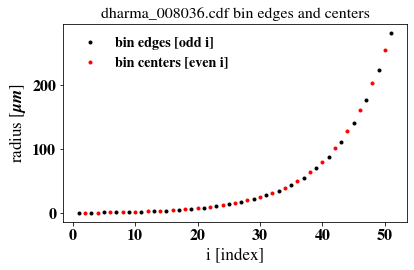

In [167]:
plt.plot(np.arange(1,52,2),r[r_l],'k.')
plt.title(DYCOMS2.fname+' bin edges and centers')
plt.plot(np.arange(2,52,2),r[lesBinCen],'r.')
plt.legend(['bin edges [odd i]','bin centers [even i]'])
plt.ylabel('radius [$\mu m$]')
plt.xlabel('i [index]')
plt.tight_layout()
cpn.savefig(plt.gcf(),DYCOMS2.fname+' bin edges and centers','figures/')

1. Assuming uniform DSD inside a bins

In [23]:
c_mie = DYCOMS2.c_mie
qe = c_mie.qe
al = c_mie.alb
r  = c_mie.d/2
r_l=DYCOMS2.get_pDefr_l(lesCname)
#r_c=lesBinCen
qe_avg=np.zeros((qe.shape[1],r_l.size-1),dtype=float)
alb_av=np.zeros_like(qe_avg,dtype=float)
#qe_avg = np.zeros((qe.shape[1],r_c.size),dtype=float)
#abl_av = np.zeros_like(qe_avg,dtype=float)
for i in np.arange(0,r_l.size-1,1):
    lt=r_l[i]
    rt=r_l[i+1]
    qe_avg[:,i]=np.einsum('ij,i->j'        ,qe[lt:rt,:],r[lt:rt]**2)/np.sum(r[lt:rt]**2)  
    alb_av[:,i]=np.einsum('ij,i,ij->j'     ,qe[lt:rt,:],r[lt:rt]**2,al[lt:rt,:],)/np.einsum('i,ij->j',r[lt:rt]**2,qe[lt:rt])
extp3d = np.einsum('ji,i,iklm->jiklm',qe_avg,DYCOMS2.DHARMA.r_drops**2,DYCOMS2.DHARMA.dN_drops)*np.pi*1e-3#km^-1
dTau=np.einsum('ijzxy,z->izxy',extp3d,DYCOMS2.dz*1e-3)   
#Miller et. al. 2017
path='/umbc/xfs1/zzbatmos/users/charaj1/taki/ACRS/LES_simulations/Miller_2017/'
f=h5py.File(path+'DHARMA_DYCOMS2_008036_Physics_Optics_VW.h5','r')
TAU_W086_total_50m=f['TAU_W086_total_50m'][:]
f.close()

In [151]:
c_mie.out_name

'DYCOM2_dharma_008036_mie_470_860_2p13'

Replace existing file?:  n


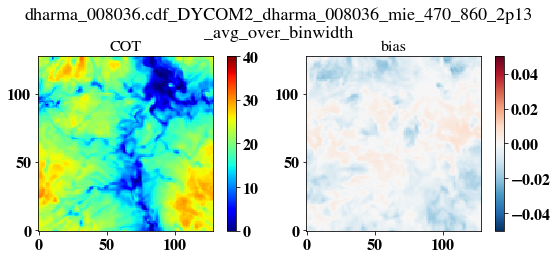

In [24]:
#dTau bias
fig1,ax1=plt.subplots(1,2,figsize=(8,4),subplot_kw={'aspect':'equal'})
fig1_ttl = DYCOMS2.fname+'_'+c_mie.out_name+'_avg_over_binwidth'
fig1.suptitle("\n".join(wrap(fig1_ttl,55)))
ctf1 = ax1[0].imshow(dTau.sum(axis=1)[1,:],origin='lower',cmap=plt.cm.jet,vmin=0,vmax=40)
ctf2 = ax1[1].imshow(dTau.sum(axis=1)[1,:]-TAU_W086_total_50m.T,origin='lower',cmap=plt.cm.RdBu_r,vmin=-.05,vmax=.05)
cpn.add_cb(fig1,ctf1,ax=ax1[0],orientation='vertical',label='')
cpn.add_cb(fig1,ctf2,ax=ax1[1],orientation='vertical',label='')
ax1[0].set_title('COT')
ax1[1].set_title('bias')
fig1.tight_layout()
cpn.savefig(fig1,fig1_ttl,'figures/')

In [25]:
extp3d.shape

(3, 25, 96, 128, 128)

2. By assuming only one drop at the bin center

In [159]:
c_mie = DYCOMS2.c_mie
qe = c_mie.qe
al = c_mie.alb
r  = c_mie.d/2
lesBinCen=np.zeros_like(DYCOMS2.DHARMA.r_drops,dtype=int)
for i in np.arange(0,DYCOMS2.DHARMA.r_drops.size):
    lesBinCen[i]=(abs(r-DYCOMS2.DHARMA.r_drops[i])).argmin()
r_c = lesBinCen
qe_avg = np.zeros((qe.shape[1],r_c.size),dtype=float)
abl_av = np.zeros_like(qe_avg,dtype=float)
for i in np.arange(0,r_c.size-1,1):
    qe_avg[:,i]=qe[i,:]  
    alb_av[:,i]=al[i,:]
extp3d = np.einsum('ji,i,iklm->jiklm',qe_avg,DYCOMS2.DHARMA.r_drops**2,DYCOMS2.DHARMA.dN_drops)*np.pi*1e-3#km^-1
dTau=np.einsum('ijzxy,z->izxy',extp3d,DYCOMS2.dz*1e-3)   

Replace existing file?:  y


figures/dharma_008036pcdf_DYCOM2_dharma_008036_mie_470_860_2p13_single_drop_at_center.png SAVED.


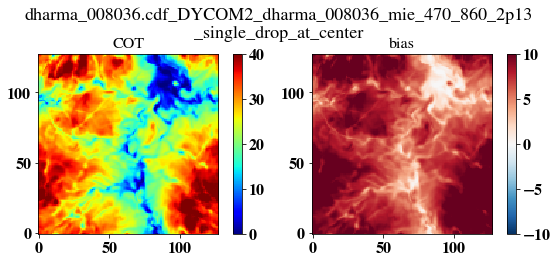

In [163]:
#dTau bias
fig1,ax1=plt.subplots(1,2,figsize=(8,4),subplot_kw={'aspect':'equal'})
fig1_ttl = DYCOMS2.fname+'_'+c_mie.out_name+'_single_drop_at_center'
fig1.suptitle("\n".join(wrap(fig1_ttl,55)))
ctf1 = ax1[0].imshow(dTau.sum(axis=1)[1,:],origin='lower',cmap=plt.cm.jet,vmin=0,vmax=40)
ctf2 = ax1[1].imshow(dTau.sum(axis=1)[1,:]-TAU_W086_total_50m.T,origin='lower',cmap=plt.cm.RdBu_r,vmin=-10,vmax=10)
cpn.add_cb(fig1,ctf1,ax=ax1[0],orientation='vertical',label='')
cpn.add_cb(fig1,ctf2,ax=ax1[1],orientation='vertical',label='')
ax1[0].set_title('COT')
ax1[1].set_title('bias')
fig1.tight_layout()
cpn.savefig(fig1,fig1_ttl,'figures/')

In [202]:
r_c

masked_array(data=[   5,   14,   25,   40,   59,   82,  111,  148,  195,
                    254,  328,  421,  538,  687,  873, 1108, 1404, 1777,
                   2247, 2839, 3585, 4525, 5710, 7202, 9082],
             mask=False,
       fill_value=999999)

In [21]:
#assuming single drop size at the bin center

AttributeError: 'DHARMA_onmp' object has no attribute 'qe_avg'

figures/dharma_008036pcdf_DYCOM2_dharma_008036_mie_470_860_2p13_Qe_vs_size_para.png SAVED.


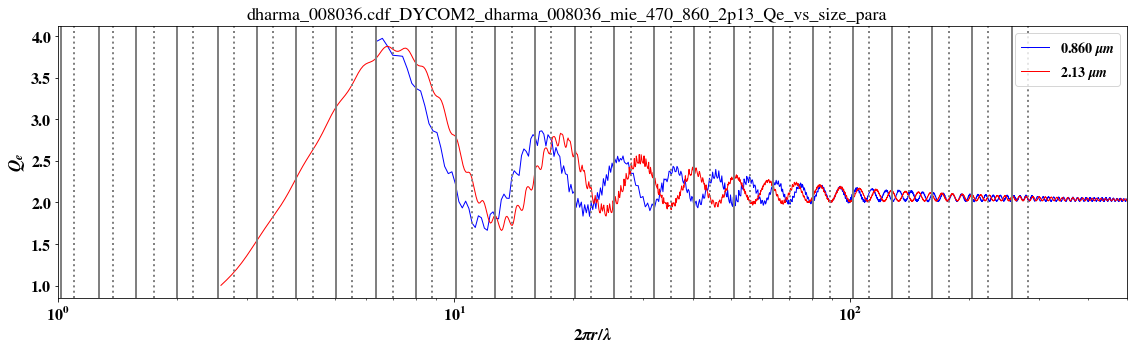

In [262]:
fig1, ax1 = plt.subplots(figsize=(16,5))
fig1_ttl = fig1_ttl = DYCOMS2.fname+'_'+c_mie.out_name+'_Qe_vs_size_para'
fig1.suptitle("\n".join(wrap(fig1_ttl,80)))
ax1.plot(2*np.pi*r/0.860,qe[:,1],'b-',linewidth=1,label='0.860 $\mu m$')
ax1.plot(2*np.pi*r/2.13,qe[:,2],'r-',linewidth=1, label='2.13 $\mu m$')
[ax1.axvline(r[i],ls=':',color='grey') for i in r_l]
[ax1.axvline(r[i],ls='-',color='grey') for i in r_c]
ax1.set_xscale('log')
ax1.set_xlabel('$2\pi r/\lambda$')
ax1.set_ylabel('$Q_e$')
ax1.legend(loc='upper right',frameon=True)
ax1.set_xlim(1,500)
fig1.tight_layout(rect=[0,0,1,0.97])
cpn.savefig(fig1,fig1_ttl,'figures/')



In [242]:
r_l


array([   0,    8,   18,   31,   47,   68,   93,  126,  166,  218,  282,
        364,  467,  596,  759,  964, 1223, 1549, 1959, 2477, 3128, 3949,
       4984, 6288, 7930, 9999])

In [65]:
r=DYCOMS2.c_mie.d/2
lesBEd=np.zeros_like(DYCOMS2.DHARMA.rbound_drops,dtype=int)
for i in np.arange(0,lesBEd.size):
    lesBEd[i]=(abs(r-DYCOMS2.DHARMA.rbound_drops[i])).argmin()
    print("i={}, r={}, rbound={}".format(lesBEd[i],r[lesBEd[i]],DYCOMS2.DHARMA.rbound_drops[i]))

i=0, r=0.8735802173614502, rbound=0.8735802173614502
i=8, r=1.0983153581619263, rbound=1.1006420850753784
i=18, r=1.3792341947555542, rbound=1.3867220878601074
i=31, r=1.7444288730621338, rbound=1.7471604347229004
i=47, r=2.193899154663086, rbound=2.201284170150757
i=68, r=2.7838287353515625, rbound=2.773444175720215
i=93, r=3.486126184463501, rbound=3.494320869445801
i=126, r=4.413158416748047, rbound=4.402568340301514
i=166, r=5.536834239959717, rbound=5.54688835144043
i=218, r=6.997612476348877, rbound=6.988641738891602
i=282, r=8.795494079589844, rbound=8.805136680603027
i=364, r=11.099028587341309, rbound=11.093778610229492
i=466, r=13.964401245117188, rbound=13.97728443145752
i=596, r=17.616348266601562, rbound=17.610275268554688
i=759, r=22.19532585144043, rbound=22.187557220458984
i=964, r=27.954164505004883, rbound=27.95456886291504
i=1223, r=35.22996520996094, rbound=35.220550537109375
i=1549, r=44.38792037963867, rbound=44.37511444091797
i=1959, r=55.90559768676758, rbound=5

In [62]:
lesBEd.astype(int)

masked_array(data=[   0,    8,   18,   31,   47,   68,   93,  126,  166,
                    218,  282,  364,  466,  596,  759,  964, 1223, 1549,
                   1959, 2476, 3128, 3949, 4984, 6287, 7930, 9999],
             mask=False,
       fill_value=-9223372036854775808)

## Miller et. al. 2017 Results

In [5]:
import h5py
mil_fname = 'DHARMA_DYCOMS2_008036_Physics_Optics_VW.h5'
path='/umbc/xfs1/zzbatmos/users/charaj1/taki/ACRS/LES_simulations/Miller_2017/'
f=h5py.File(path+mil_fname,'r')
re_2wt_50m=f['RE_2WT_50m'][:]
ve_2wt_50m=f['VE_2WT_50m'][:]
re_2wt_100m=f['RE_2WT_100m'][:]
dn_drops = f['DN_DROPS'][:]
TAU_W086 = f['TAU_W086'][:]

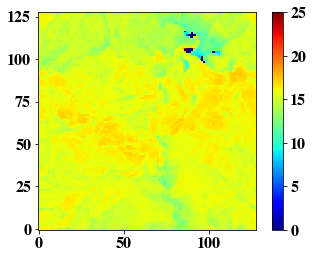

In [163]:
plt.imshow(re_2wt_50m[0,0,0,:].T,cmap=plt.cm.jet,vmin=0,vmax=25,origin='lower')
plt.colorbar()

In [19]:
for key in f.keys():
    print(f[key])

<HDF5 group "/#refs#" (1 members)>
<HDF5 dataset "DN_DROPS": shape (25, 96, 128, 128), type "<f8">
<HDF5 group "/LWC" (1 members)>
<HDF5 dataset "LWP_100m": shape (64, 64), type "<f8">
<HDF5 dataset "LWP_200m": shape (32, 32), type "<f8">
<HDF5 dataset "LWP_400m": shape (16, 16), type "<f8">
<HDF5 dataset "LWP_50m": shape (128, 128), type "<f8">
<HDF5 dataset "LWP_800m": shape (8, 8), type "<f8">
<HDF5 dataset "N_2WT_dist100m": shape (25, 64, 64), type "<f8">
<HDF5 dataset "N_2WT_dist200m": shape (25, 32, 32), type "<f8">
<HDF5 dataset "N_2WT_dist400m": shape (25, 16, 16), type "<f8">
<HDF5 dataset "N_2WT_dist50m": shape (25, 128, 128), type "<f8">
<HDF5 dataset "N_2WT_dist800m": shape (25, 8, 8), type "<f8">
<HDF5 dataset "RBIN": shape (25, 1, 1, 1), type "<f8">
<HDF5 dataset "RE_2WT_100m": shape (3, 3, 7, 64, 64), type "<f8">
<HDF5 dataset "RE_2WT_200m": shape (3, 3, 7, 32, 32), type "<f8">
<HDF5 dataset "RE_2WT_400m": shape (3, 3, 7, 16, 16), type "<f8">
<HDF5 dataset "RE_2WT_50m": 

/umbc/xfs1/zzbatmos/users/charaj1/taki/softs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log10
/umbc/xfs1/zzbatmos/users/charaj1/taki/softs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in log10


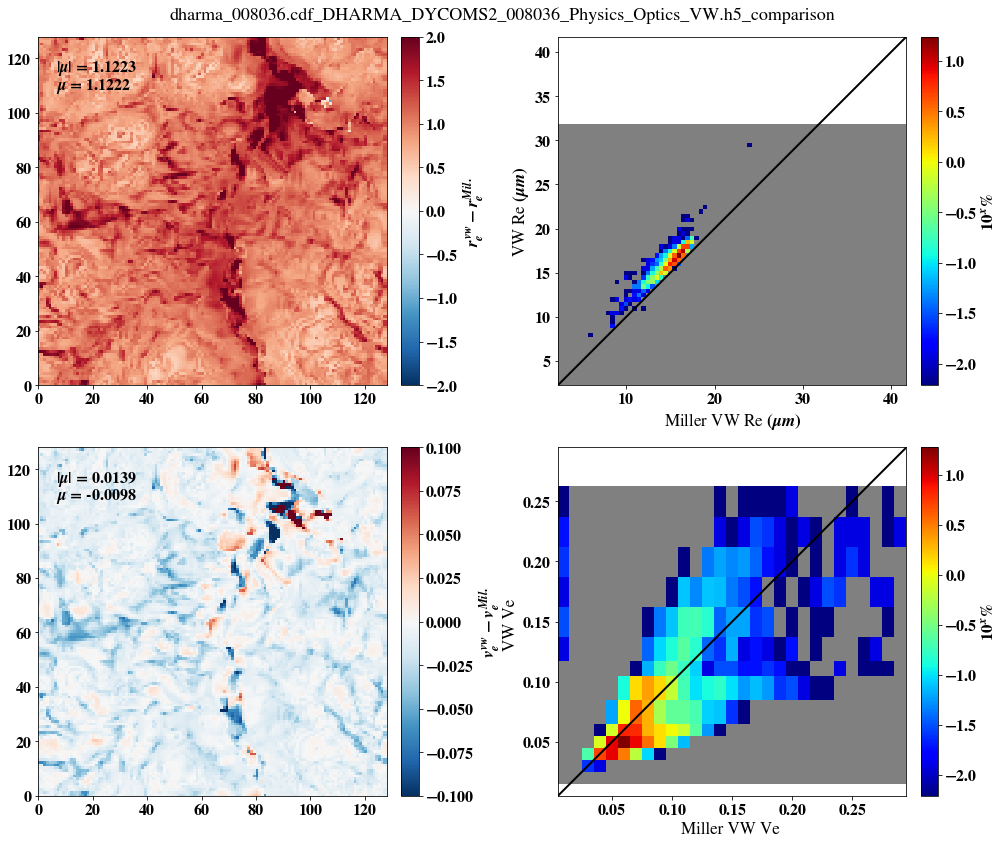

In [7]:
from cpnRetrievalslib import Pol_ret_P12Lib
cmap=plt.cm.jet    
cmap_0=plt.cm.RdBu_r
cmap.set_bad(color='gray')
cmap_0.set_bad(color='gray')
def set2DHist(xbnds,ybnds,valX,valY):
    '''
    Returns:
        val
        xc,yc: bin centers
            .contourf(xc,yc,np.log10(val.T/val.sum()*100),levels=50,extend='both',cmap=plt.cm.jet)
        xm,ym: bin meshes
            .pcolormesh(xm,ym,np.log10(val.T/val.sum()*100),cmap=plt.cm.jet)
    '''
    val,xedges,yedges=np.histogram2d(valX,valY, bins=(xbnds,ybnds))
    xc=(xedges[0:-1]+xedges[1:])/2
    yc=(yedges[0:-1]+yedges[1:])/2
    xm, ym = np.meshgrid(xc,yc)
    return val,xc,yc,xm,ym    
#pol. ret. comparison with vw
re_vw = DYCOMS2.VW.Re #Re_vw
ve_vw = DYCOMS2.VW.Ve #Ve_vw
P12Lib=Pol_ret_P12Lib(fname='Pol_ret_PM_library_0p860_2p13_V3.hdf5')
P12Lib.loadP12Lib()
# make these smaller to increase the resolution
#dx, dy = 0.05, 0.05
fig1_ttl = fig1_ttl = DYCOMS2.fname+'_'+mil_fname+'_comparison'
fig1, ax1=plt.subplots(2,2,figsize=(14,12),subplot_kw={'aspect':'equal'})
val,_,_,x,y=set2DHist(np.linspace(2,42,81),np.linspace(2,32,61),re_2wt_50m[0,0,0,:].T.flatten(),re_vw.flatten())
ctf1=ax1[0,1].pcolormesh(x,y,np.log10(val.T/val.sum()*100),cmap=plt.cm.jet)
val,_,_,x,y=set2DHist(np.linspace(0,0.3,31),P12Lib.ve,ve_2wt_50m[0,0,0,:].T.flatten(),ve_vw.flatten())
ctf2=ax1[1,1].pcolormesh(x,y,np.log10(val.T/val.sum()*100),cmap=plt.cm.jet)
ctf3=ax1[0,0].pcolormesh(re_vw-re_2wt_50m[0,0,0,:].T,cmap=cmap_0,vmin=-2,vmax=2)
ctf4=ax1[1,0].pcolormesh(ve_vw-ve_2wt_50m[0,0,0,:].T,cmap=cmap_0,vmin=-.1,vmax=.1)
#ax1[1].set_xscale('log')
#ax1[1].set_yscale('log')
#ax1.contourf(xc,yc,np.log10(val.T/val.sum()*100),levels=50,extend='both',cmap=plt.cm.jet)
cpn.add_cb(fig1,ctf1,ax1[0,1],orientation='vertical',label='$10^x\%$')
cpn.add_cb(fig1,ctf2,ax1[1,1],orientation='vertical',label='$10^x\%$')
cpn.add_cb(fig1,ctf3,ax1[0,0],orientation='vertical',label='$r_e^{vw}-r_e^{Mil.}$')
cpn.add_cb(fig1,ctf4,ax1[1,0],orientation='vertical',label='$v_e^{vw}-v_e^{Mil.}$')
ax1[0,1].set_xlabel('Miller VW Re $(\mu m)$')
ax1[0,1].set_ylabel('VW Re $(\mu m)$')
ax1[1,1].set_xlabel('Miller VW Ve ')
ax1[1,1].set_ylabel('VW Ve ')
cpn.Corr_plot_frames(ax1[0,1],lineS='k-',linewidth=2.0)
cpn.Corr_plot_frames(ax1[1,1],lineS='k-',linewidth=2.0)
ax1[0,0].text(0.05,0.90,'$|\mu|$ = %0.4f'%(np.nanmean(abs(re_vw-re_2wt_50m[0,0,0,:].T))),transform=ax1[0,0].transAxes,size=16)
ax1[0,0].text(0.05,0.85,       '$\mu$ = %0.4f'%(np.nanmean(re_vw-re_2wt_50m[0,0,0,:].T)),transform=ax1[0,0].transAxes,size=16)
ax1[1,0].text(0.05,0.90,'$|\mu|$ = %0.4f'%(np.nanmean(abs(ve_vw-ve_2wt_50m[0,0,0,:].T))),transform=ax1[1,0].transAxes,size=16)
ax1[1,0].text(0.05,0.85,       '$\mu$ = %0.4f'%(np.nanmean(ve_vw-ve_2wt_50m[0,0,0,:].T)),transform=ax1[1,0].transAxes,size=16)
fig1.suptitle("\n".join(wrap(fig1_ttl,80)))
fig1.tight_layout(rect=[0,0,1,0.97])
#cpn.savefig(fig1,fig1_ttl,'figures/')

/umbc/xfs1/zzbatmos/users/charaj1/taki/softs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log10
/umbc/xfs1/zzbatmos/users/charaj1/taki/softs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in log10


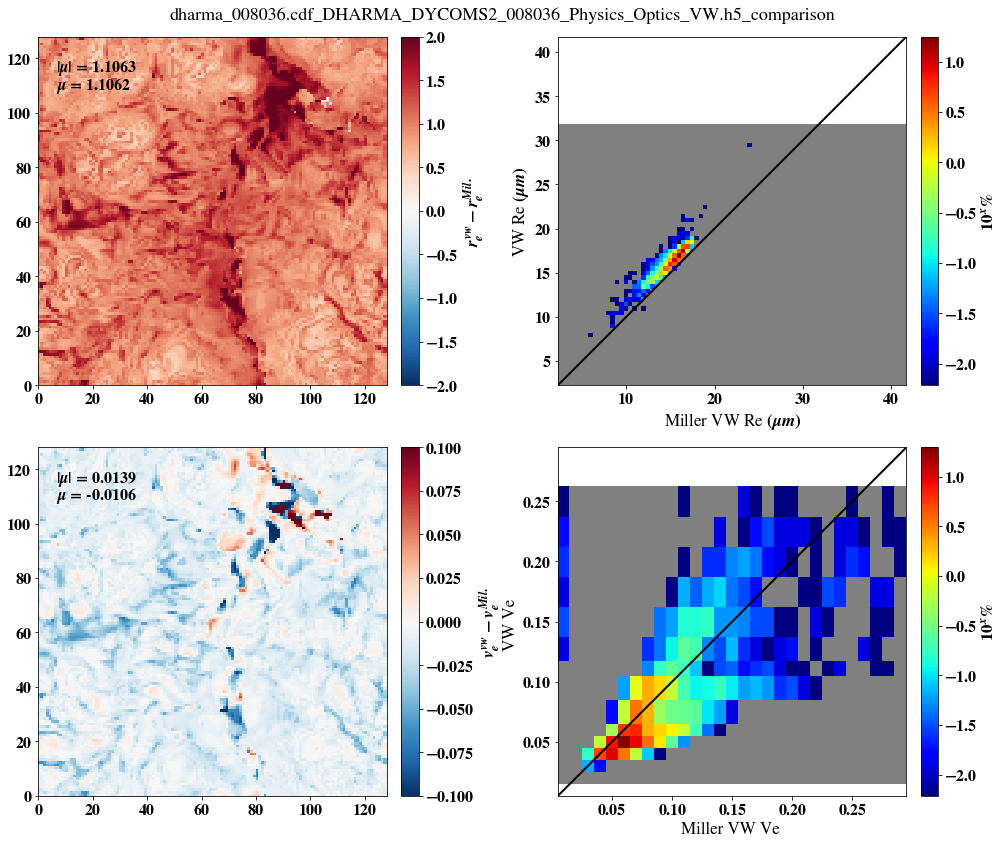

In [165]:
DYCOMS2.VW.Re.shape

(128, 128)

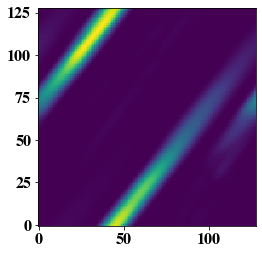

In [124]:
plt.imshow(tau_w086[-1,:],origin='lower')

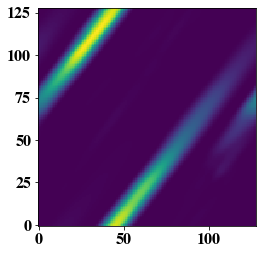

In [127]:
plt.imshow(DYCOMS2.dTau[1,-1,:].T,origin='lower')

In [114]:
f.keys()

<KeysViewHDF5 ['#refs#', 'DN_DROPS', 'LWC', 'LWP_100m', 'LWP_200m', 'LWP_400m', 'LWP_50m', 'LWP_800m', 'N_2WT_dist100m', 'N_2WT_dist200m', 'N_2WT_dist400m', 'N_2WT_dist50m', 'N_2WT_dist800m', 'RBIN', 'RE_2WT_100m', 'RE_2WT_200m', 'RE_2WT_400m', 'RE_2WT_50m', 'RE_2WT_800m', 'RE_2WT_rmv_TZ', 'RE_2WT_rmv_drz', 'TAU_W086', 'TAU_W086_total_100m', 'TAU_W086_total_200m', 'TAU_W086_total_400m', 'TAU_W086_total_50m', 'TAU_W086_total_800m', 'TAU_W213', 'TAU_W375', 'VE_2WT_100m', 'VE_2WT_200m', 'VE_2WT_400m', 'VE_2WT_50m', 'VE_2WT_800m', 'VE_2WT_rmv_TZ', 'VE_2WT_rmv_drz', 'X_100m', 'X_200m', 'X_400m', 'X_50m', 'X_800m', 'Y_100m', 'Y_200m', 'Y_400m', 'Y_50m', 'Y_800m', 'Z_LES']>

In [146]:
(f['RE_2WT_rmv_drz'][:]).shape

(3, 3, 7, 128, 128)

(array([18.,  4.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  1.]),
 array([3.15714670e-15, 1.72304000e+00, 3.44607999e+00, 5.16911999e+00,
        6.89215998e+00, 8.61519998e+00, 1.03382400e+01, 1.20612800e+01,
        1.37843200e+01, 1.55073600e+01, 1.72304000e+01]),
 <a list of 10 Patch objects>)

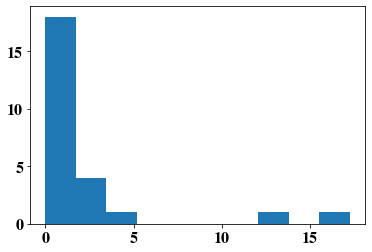

In [141]:
plt.hist((f['N_2WT_dist50m'][:])[:,120,30])

0.00211271035882554


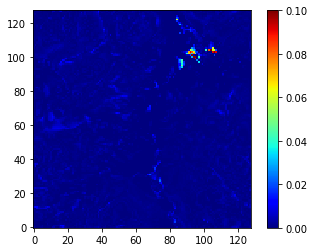

In [11]:
fig1,ax1=plt.subplots()
ctf=ax1.imshow(DYCOMS2.VW.Ve-DYCOMS2.VW.Ve_dN_vw,origin='lower',vmin=0,vmax=0.1,cmap=plt.cm.jet)
fig1.colorbar(ctf)
print(np.mean(abs(DYCOMS2.VW.Ve-DYCOMS2.VW.Ve_dN_vw)))

0.09226362520220424


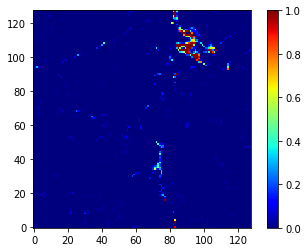

In [90]:
fig1,ax1=plt.subplots()
ctf=ax1.imshow(Re_vw-re_Nvw2,origin='lower',vmin=0,vmax=1,cmap=plt.cm.jet)
fig1.colorbar(ctf)
print(np.mean(abs(Re_vw-re_Nvw2)))

In [11]:
vars(DYCOMS2.VW).keys()



dict_keys(['replace', 'fname', 'mie_path', 'les_onmp', 'fpath', 'Re', 'Ve', 'Re_dN_vw', 'Ve_dN_vw', 'Tau', 'dN', 're_tau', 've_tau', 'w_tau', 'tau', 'x', 'y', 'z'])

In [15]:
vwwt=c*w_tauDIVc

In [13]:
c.shape

(128, 128)

In [16]:
vwwt.shape

(96, 128, 128)